In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torchaudio
import torch.nn.functional as F
import timm
import numpy as np
import matplotlib.pyplot as plt
import cv2
import stylegan_generator

In [2]:
def swish(x):
    return x * torch.sigmoid(x)

In [3]:
F.swish = swish

In [4]:
# from pyffmpeg import FFmpeg

# inp = 'demo.mp4'
# out = 'demo.mp3'

# ff = FFmpeg()

# output_file = ff.convert(inp, out)

# print(output_file)

In [5]:
import torchaudio
sample_rate = 44100

waveform, sample_rate = torchaudio.load('demo.mp3',frame_offset=16*sample_rate,num_frames=32*sample_rate)

In [6]:
waveform[0,]

tensor([0.0156, 0.0164, 0.0210,  ..., 0.2135, 0.1971, 0.1792])

In [7]:
import matplotlib.pyplot as plt

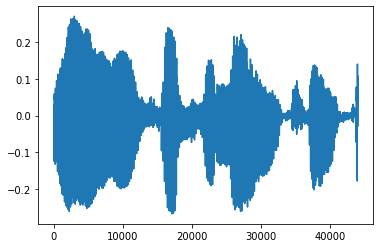

In [8]:
plt.plot(waveform[0,:sample_rate])

In [9]:

class VideoFeatureNet(nn.Module):
    def __init__(self, model_name='efficientnet_b3', num_classes=0, pretrained=False):
        super(VideoFeatureNet, self).__init__()
        #in images_num, channels, height, width 
        self.model = timm.create_model(model_name,pretrained=pretrained,num_classes=num_classes)
        #out images_num, 1536, 12, 20
        self.pool = nn.AdaptiveAvgPool2d(1)
        #pooled images_num, 1536
        self.affine = nn.Linear(1536,1024)
    
    def forward(self, x):
        x = self.model.forward_features(x)
        x = self.pool(x)
        x = x.view(x.shape[0],-1)
        x = self.affine(x)
        return x
        
        

In [10]:
class AudioFeatureNet(nn.Module):
    def __init__(self,):
        #extracting features from audio
        super(AudioFeatureNet, self).__init__()
        self.bundle = torchaudio.pipelines.HUBERT_BASE
        self.model = self.bundle.get_model()
        self.sample_rate = self.bundle.sample_rate
        self.pool = nn.AdaptiveAvgPool2d((1,768))
    
    def forward(self,waveform):
        waveform = torchaudio.functional.resample(waveform, 44100, self.bundle.sample_rate)
        features, _ = self.model.extract_features(waveform)
        print(features[2].shape)
        return self.pool(features[-1]).squeeze(1)
        


In [11]:
class GeneratorNet(nn.Module):
    def __init__(self,resolution=512):
        super().__init__()
        self.gen = stylegan_generator.StyleGANGenerator(resolution=512)
        
    def forward(self,z):
        ret = self.gen(z)
        return ret


In [12]:
class SemanticsExtractNet(nn.Module):
    def __init__(self, AudioFeatureSubNet, VideoFeatureSubNet, out_size=1024):
        super().__init__()
        # video 1024 Audio 768
        self.Audio_feature_subnet = AudioFeatureSubNet
        self.Video_feature_subnet = VideoFeatureSubNet
        self.fusion_net = nn.Linear(1024+768, out_size)
    
    def forward(self,image,waveform,audio_feature=None):
        image_feature = self.Video_feature_subnet(image)
        if audio_feature is None:
            audio_feature = self.Audio_feature_subnet(waveform)
        feature = torch.cat((image_feature,audio_feature),dim=-1)
        out = self.fusion_net(feature)
        return out,image_feature,audio_feature
        

In [13]:
class SemanticsPredictNet(nn.Module):
    def __init__(self, AudioFeatureSubNet, out_size=1024):
        super().__init__()
        # video 1024 Audio 768
        self.semantics_affine = nn.Linear(out_size, 768)
        self.Audio_feature_subnet = AudioFeatureSubNet
        self.fusion_net = nn.Linear(768+768, out_size)

    def forward(self, old_semantics, waveform,audio_feature=None):
        print(old_semantics)
        affined_semantics = self.semantics_affine(old_semantics)
        affined_semantics = swish(affined_semantics)
        if audio_feature is None:
            audio_feature = self.Audio_feature_subnet(waveform)
        # audio_feature = self.Audio_feature_subnet(waveform)
        feature = torch.cat((affined_semantics, audio_feature), dim=-1)
        out = self.fusion_net(feature)
        return out,audio_feature


In [14]:
class SemanticsVAE(nn.Module):
    def __init__(self, in_size=512,out_size=512,hidden_size=128):
        super().__init__()
        # video 1024 Audio 768
        self.feature_affine = nn.Linear(in_size, out_size)
        self.averaging = nn.Linear(out_size, hidden_size)
        self.variance = nn.Linear(out_size, hidden_size)
        self.sampling = nn.Linear(hidden_size, out_size)
        self.out_affine = nn.Linear(out_size, out_size)
        
    def encode(self, x):
        #in affined semantics
        #out miu,log sigma
        affined_semantics = F.relu(self.feature_affine(x))
        return self.averaging(affined_semantics), self.variance(affined_semantics)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        sample_semantics = F.relu(self.sampling(z))
        return self.out_affine(sample_semantics)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def loss_function(self, mu, logvar, x, recon_x):
        # Reconstruction + KL divergence losses summed over all elements and batch
        BCE = F.mse_loss(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD


In [15]:
class VideoPredictionNet(nn.Module):
    def __init__(self, VideoFeatureSubNet, GeneratorSubNet, SemanticsVAESubNet,video_feature_size=1024,semantics_size=1024,latent_size=512):
        super().__init__()
        self.video_feature_subnet = VideoFeatureSubNet
        self.generator_subnet = GeneratorSubNet
        self.semantics_fusion = nn.Linear(video_feature_size+semantics_size, latent_size)
        self.semantics_vae_subnet = SemanticsVAESubNet
    
    def forward(self, image, semantics,image_feature=None):
        if image_feature is None:
            image_feature = self.video_feature_subnet(image)
        #image_feature = self.video_feature_subnet(image)
        semantics = torch.cat((image_feature, semantics), dim=-1)
        semantics = swish(self.semantics_fusion(semantics))
        sampled_semantics,mu,sigma = self.semantics_vae_subnet(semantics)
        return self.generator_subnet(sampled_semantics), image_feature, (mu, sigma,semantics,sampled_semantics)


In [16]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.01,DistanceFunc=F.mse_loss):
        super().__init__()
        self.margin = margin
        self.dist = DistanceFunc
    
    def forward(self, anchor, positive, negative):
        pos_dist = self.dist(anchor, positive)
        neg_dist = self.dist(anchor, negative)
        loss = torch.clamp(self.margin + pos_dist - neg_dist, min=0.0)
        return loss.mean()

In [17]:
class simpleWassersteinDistance(nn.Module):
    def __init__(self,geometric=True):
        super().__init__()
        self.geometric = geometric
        
    def pairwise_distance(self, negative, positive):
        return torch.mean(self.geometric(negative)-self.geometric(positive))
    
    def single_distance(self, negative):
        return self.geometric(negative)


In [18]:
class simpleConstrastiveDistance(nn.Module):
    def __init__(self, geometric=True):
        super().__init__()
        self.geometric = geometric

    def pairwise_distance(self, negative, positive):
        with torch.no_grad():
            positive_dist = self.geometric(positive)
        return torch.mean(self.geometric(negative)-positive_dist)

    def single_distance(self, negative):
        return self.geometric(negative)


In [19]:
#save computation,pass image features directly
class VideoDescriminator(nn.Module):
    def __init__(self, in_size=1024, out_size=32,):
        super().__init__()
        self.affine = nn.Linear(in_size, out_size)
    
    def forward(self, x):
        return swish(self.affine(swish(x)))

In [20]:
class DirectorNet(nn.Module):
    def __init__(self, SemanticsExtractSubNet, SemanticsPredictSubNet, VideoPredictionSubNet, VideoDescriminatorSubNet,semantics_size=1024, latent_size=512):
        super().__init__()
        self.semantics_extract_net = SemanticsExtractSubNet
        self.semantics_predict_net = SemanticsPredictSubNet
        self.video_prediction_net = VideoPredictionSubNet
        self.semantics_size = semantics_size
        self.latent_size = latent_size
        self.mse_triplet_loss = TripletLoss(DistanceFunc=torch.nn.CosineSimilarity())
        self.video_triplet_loss = TripletLoss(DistanceFunc=F.pairwise_distance)
        self.video_Net_loss = TripletLoss(DistanceFunc=F.mse_loss)
        self.wasserstein_distance = simpleWassersteinDistance(
            VideoDescriminatorSubNet)
        self.constrastive_distance = simpleConstrastiveDistance(
            VideoDescriminatorSubNet)
        self.video_discriminator_subnet = VideoDescriminatorSubNet
        
    def forward(self, image, waveform):
        semantics_now,image_feature,audio_feature = self.semantics_extract_net(image, waveform)
        semantics_pred,audio_feature = self.semantics_predict_net(semantics_now, waveform,audio_feature)
        video_pred,image_feature,vae_vars = self.video_prediction_net(image, semantics_pred,image_feature)
        return video_pred, semantics_now, semantics_pred,image_feature,audio_feature,vae_vars
    
    def train_step(self, image, waveform, target_image, target_waveform):
        video_pred, semantics_now, semantics_pred,image_feature,audio_feature,vae_vars = self.forward(image, waveform)
        image_pred = video_pred["image"]
        # with torch.no_grad():
        target_semantics,target_image_feature,target_audio_feature = self.semantics_extract_net(target_image, target_waveform)
        recurrent_semantics,image_pred_feature,_ = self.semantics_extract_net(image_pred, target_waveform, target_audio_feature)
        loss_semantics = self.mse_triplet_loss(semantics_pred, target_semantics,semantics_now)
        loss_recurrent_semantics = self.mse_triplet_loss(recurrent_semantics, target_semantics,semantics_now)
        loss_video = self.video_triplet_loss(image_pred, target_image, image)
        loss_video_Net = self.video_Net_loss(self.video_discriminator_subnet(image_pred_feature), self.video_discriminator_subnet(target_image_feature),self.video_discriminator_subnet(image_feature))
        # loss_video_wasserstein = self.wasserstein_distance.pairwise_distance(image_feature, target_image_feature)
        loss_vae = self.video_prediction_net.semantics_vae_subnet.loss_function(*vae_vars)
        # loss_video_constrastive = self.wasserstein_distance.pairwise_distance(image_feature, target_image_feature)
        # for i in [loss_semantics,loss_recurrent_semantics,loss_video,loss_video_wasserstein,loss_vae,loss_video_constrastive]:
        #     print("loss shape",i.shape)
        loss = loss_semantics + loss_recurrent_semantics + loss_video + loss_video_Net +loss_vae#+ loss_video_wasserstein + loss_video_constrastive#+ loss_vae+
        return loss,image_pred

In [21]:
def create_director_net():
    VideoFeatureSubNet = VideoFeatureNet().cuda()
    AudioFeatureSubNet = AudioFeatureNet().cuda()
    GeneratorSubNet = GeneratorNet().cuda()
    SemanticsVAESubNet = SemanticsVAE().cuda()
    SemanticsExtractSubNet = SemanticsExtractNet(AudioFeatureSubNet, VideoFeatureSubNet).cuda()
    VideoDescriminatorSubNet = VideoDescriminator().cuda()
    SemanticsPredictSubNet = SemanticsPredictNet(AudioFeatureSubNet).cuda()
    VideoPredictionSubNet = VideoPredictionNet(VideoFeatureSubNet, GeneratorSubNet, SemanticsVAESubNet).cuda()
    director_net = DirectorNet(SemanticsExtractSubNet, SemanticsPredictSubNet,VideoPredictionSubNet, VideoDescriminatorSubNet).cuda()
    
    return director_net


model = create_director_net()


In [22]:
from pytorch_ranger import Ranger 
opt = Ranger(model.parameters())
# opt = torch.optim.Adam(model.parameters(), lr=5e-6, weight_decay=1e-5)

In [23]:
n = 0

In [24]:
# with torch.inference_mode():
cap = cv2.VideoCapture('./demo.mp4')
old_img = None
old_audio = None

flag = True
while cap.isOpened():
    n += 1

    ret, image = cap.read()
    if n <= 150:
        continue
    cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imshow("444",image)
    cv2.waitKey(1) & 0xFF == ord('q')
    image_height, image_width, _ = image.shape
    image = cv2.resize(image, (512, 512))
    img = torch.tensor(image).unsqueeze(0).permute(0, 3, 1, 2).float()
    print(img.shape)
    print(n)
    if flag != True:
        opt.zero_grad()
        tensor = model.train_step(old_img.cuda(),old_audio.cuda(),img.cuda(), waveform[[0], 44100//30*(n - 1):44100//30 * n].cuda())
        loss = tensor[0]
        print(loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        cv2.imshow("555", tensor[1].cpu().permute(0, 2, 3, 1).detach().numpy()[0])
        cv2.waitKey(1) & 0xFF == ord('q')
    flag = False
    old_img = img
    old_audio = waveform[[0], 44100//30*(n - 1):44100//30 * n]
    if n > 9999:
        cap.release()
        break



torch.Size([1, 3, 512, 512])
151
torch.Size([1, 3, 512, 512])
152
torch.Size([1, 1, 768])
tensor([[-0.0794, -0.0588,  0.2151,  ..., -0.2765, -0.0665, -0.2457]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
torch.Size([1, 1, 768])
tensor(7.6050, device='cuda:0', grad_fn=<AddBackward0>)


/home/qq/.local/lib/python3.9/site-packages/pytorch_ranger/ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


torch.Size([1, 3, 512, 512])
153
torch.Size([1, 1, 768])
tensor([[-0.0575,  0.0361,  0.3105,  ..., -0.0855,  0.0430, -0.1688]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
torch.Size([1, 1, 768])
tensor(8.4052, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([1, 3, 512, 512])
154
torch.Size([1, 1, 768])
tensor([[-0.0293,  0.0416,  0.1670,  ..., -0.1957, -0.0459,  0.0163]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
torch.Size([1, 1, 768])
tensor(7.3121, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([1, 3, 512, 512])
155
torch.Size([1, 1, 768])
tensor([[-0.0388,  0.0339,  0.2453,  ..., -0.1583, -0.1713, -0.2376]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
torch.Size([1, 1, 768])
tensor(8.3381, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([1, 3, 512, 512])
156
torch.Size([1, 1, 768])
tensor([[-0.0038,  0.0010,  0.2089,  ..., -0.2578, -0.1998, -0.0760]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
torch.Size([1, 1, 768])
tensor(7.8913, device='c